In [1]:
import sys, os
COLAB = 'google.colab' in sys.modules 
if COLAB and 'procgen-tools' not in os.getcwd():
    os.system("git clone https://github.com/UlisseMini/procgen-tools")
    os.chdir('procgen-tools')
    %pip install -r requirements.txt

In [2]:
%load_ext autoreload
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from procgen import ProcgenGym3Env
import envs.maze as maze
from models import load_policy
import torch
from IPython import display
from glob import glob
import pickle
from tqdm import tqdm
import os

In [3]:
def typecheck(l: dict):
    # Typecheck loaded stuff (prevents weird errors lower down if wrong)
    # TODO: Use validation lib (nicer errors)
    assert type(l["level_seed"]) == int
    
    assert isinstance(l["actions"], list)
    assert all(type(a) == int for a in l["actions"])

    assert isinstance(l["rewards"], list)
    assert all(type(r) == float for r in l["rewards"])

    assert isinstance(l["mouse_positions"], list)
    assert all(type(t) == tuple for t in l["mouse_positions"])

    assert isinstance(l["grid"], np.ndarray)

In [4]:
def load_run(file: str, load_venv=False):
    """
    Load a run from a file, optionally load the venv, allowing us to reconstruct the high-def
    image of the maze (stored in run["start_info"]["rgb"])
    (Disabled by default as it's really slow)
    """
    with open(file, 'rb') as f:
        run = pickle.load(f)

    typecheck(run)

    if load_venv:
        venv = ProcgenGym3Env(
            num=1, env_name='maze', num_levels=1, start_level=run["level_seed"],
            distribution_mode='hard', render_mode='rgb_array'
        )
        venv = maze.wrap_venv(venv)
        info = venv.env.get_info()[0]
        assert run["level_seed"] == info["level_seed"], 'level seed doesnt match created env'
        run["start_info"] = info

    return run

In [5]:
files = glob('data/model*ep*.pkl')
for f in files:
    try:
        load_run(f, load_venv=False)
    except (AssertionError, KeyError) as e:
        # delete malformed file
        print(f"Deleting malformed file {f}: {e}")
        os.remove(f)

In [6]:
files = glob('data/model*ep*.pkl')
load_venv = True
runs = [load_run(f, load_venv) for f in tqdm(files[:100])]


  0%|          | 0/100 [00:00<?, ?it/s]

building procgen...done


100%|██████████| 100/100 [00:01<00:00, 60.17it/s]


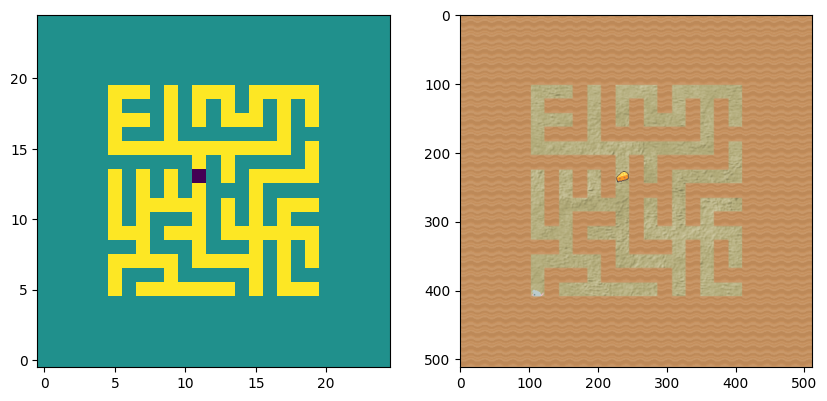

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
R = 3
ax[0].imshow(runs[R]["grid"], origin='lower')
if load_venv: ax[1].imshow(runs[R]["start_info"]["rgb"])
plt.show()

## Compute shortest path

In [8]:
# TODO: Get rid of mouse_positions, just use grid (coordinates are painful)
# (perhaps hide _mouse_positions and construct grids on the fly)
grid = runs[R]["grid"].copy()
mx, my = runs[R]["mouse_positions"][0]
grid[mx, my] = maze.MOUSE

# this bullshit is downstream of coordinate changes, would be fixed if I stored
# stuff in grids more
grid = maze.inner_grid(grid)
cx, cy = maze.get_cheese_pos(grid)
mx, my = maze.get_mouse_pos(grid)

cost, came_from = maze.shortest_path(grid, (mx, my))
dist_to_cheese = cost[cx, cy]

# came_from can be used to reconstruct the paths with this neat list-comprehension
path = [(cx, cy)]
while path[-1] in came_from:
    path += [came_from[path[-1]]]
path = path[::-1][2:] # reverse, remove start, end
print(len(path), dist_to_cheese, path)

14 14 [(1, 0), (2, 0), (2, 1), (2, 2), (3, 2), (4, 2), (5, 2), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 6), (8, 6)]


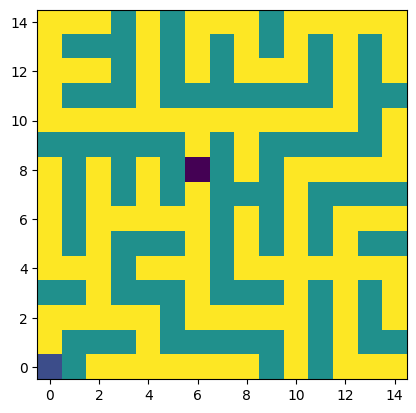

In [9]:
plt.imshow(grid, origin='lower')


In [11]:

maze.outer_grid(grid, state_vals['world_dim'])

NameError: name 'state_vals' is not defined

## Replay a run

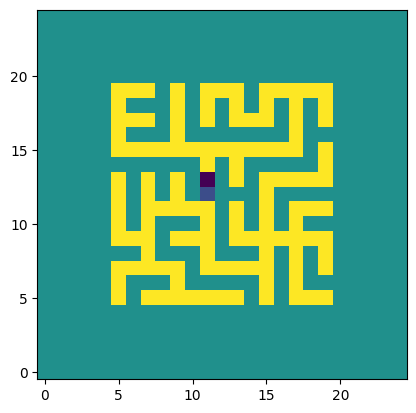

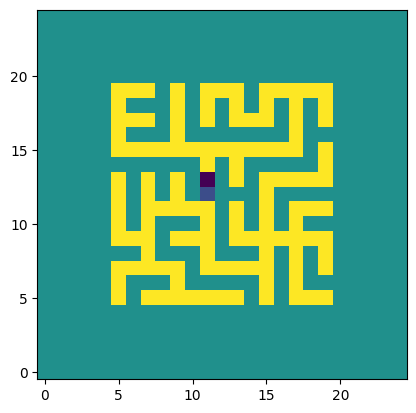

In [9]:
r = runs[R]
for t in range(0, len(r["mouse_positions"])):
    grid = r["grid"].copy()
    mx, my = r["mouse_positions"][t]
    grid[mx, my] = maze.MOUSE
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.imshow(grid, origin='lower')

## Plot distance(mouse, cheese)

In [9]:
# This is bullshit and I will remove it when I get rid of inner/outer grid coordinate shifting
def short_helper(grid, cheese, mouse) -> int:
    grid[cheese] = maze.CHEESE
    cost, _ = maze.shortest_path(grid, start=mouse)
    cheese_loc = maze.get_cheese_pos(maze.inner_grid(grid))
    return cost[cheese_loc]

In [10]:
distances = [0] * 257
distances_l2 = [0] * 257
nums = [0] * 257
for i, r in enumerate(runs):
    cx, cy = maze.get_cheese_pos(r['grid'])
    for t, (x,y) in enumerate(r["mouse_positions"]):
        nums[t] += 1
        distances[t] += short_helper(r["grid"].copy(), (cx,cy), (x,y))
        distances_l2[t] += np.sqrt((cx-x)**2 + (cy-y)**2)


distances = [distances[i] / max(1,nums[i]) for i in range(len(distances))]
distances_l2 = [distances_l2[i] / max(1,nums[i]) for i in range(len(distances_l2))]

IndexError: index 9 is out of bounds for axis 1 with size 9

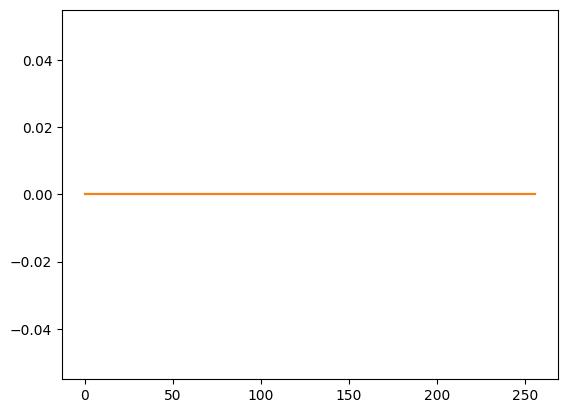

In [ ]:
plt.plot(distances)
plt.plot(distances_l2)
plt.show()